In [35]:
import torch
from transformers import GPT2Tokenizer, GPT2Model
import matplotlib.pyplot as plt
import numpy as np


## Do LLMs need LayerNorm?


### Differences Between LayerNorm and RMSNorm
*Describe what geometric effect LayerNorm has on the activations. Describe how RMSNorm differs from LayerNorm.*

**LayerNorm:**

$$
\text{LayerNorm}(x) = \frac{x - \mu}{\sigma} \cdot \gamma + \beta
$$

Where:
- $x$ = input activations  
- $\mu = \text{mean}(x)$ (feature mean)  
- $\sigma = \sqrt{\text{variance}(x)}$ (feature standard deviation)  
- $\gamma, \beta$ = learnable parameters for scale and shift  

**RMSNorm:**

$$
\text{RMSNorm}(x) = \frac{x}{\text{RMS}(x)} \cdot \gamma
$$

Where:
$$
\text{RMS}(x) = \sqrt{\frac{1}{d} \sum_{i=1}^d x_i^2}
$$

- $d$ = feature dimension  
- $\gamma$ = learnable scaling parameter (no shift parameter in RMSNorm)  

1. LayerNorm (Layer Normalization) normalizes the activations of a neural network layer along the feature dimension. This normalization ensures that the activations of each input to a layer have zero mean and unit variance across features for each data sample. Some notes:
    -  LayerNorm removes the mean of the activations, centering them around zero. Geometrically, this translates to shifting the activations so that their centroid lies at the origin in the feature space.
    - LayerNorm scales the activations so that their variance becomes 1. Geometrically, this rescales the activations to lie on the surface of a unit hypersphere (in terms of their distribution).
    - After normalization, LayerNorm applies learnable scaling (gamma) and shifting (beta). These parameters allow the network to adjust the normalized activations to the optimal scale and offset during training.


2. RMSNorm (Root Mean Square Normalization) is a simpler variant of LayerNorm that avoids mean-centering the activations. Instead, it normalizes the activations using their root mean square (RMS) without subtracting the mean. Some notes:
    - LayerNorm subtracts the mean (𝜇) of the activations, centering them around zero.RMSNorm does not subtract the mean, avoiding centering.
    - RMSNorm rescales the activations so that their magnitude in the feature space is fixed to a unit RMS value. Unlike LayerNorm, which normalizes both the mean and variance, RMSNorm focuses only on ensuring consistent magnitude, leaving the direction of the activations in the feature space unchanged.

*Key Differences* :
LayerNorm: Centers activations around the origin (by subtracting the mean) and projects them onto a unit hypersphere (unit variance)
RMSNorm: Rescales activations to have unit norm without centering. This normalization preserves the direction of activations but adjusts their magnitude.


References: 
1. https://medium.com/@florian_algo/batchnorm-and-layernorm-2637f46a998b
2. https://wandb.ai/wandb_fc/LayerNorm/reports/Layer-Normalization-in-Pytorch-With-Examples---VmlldzoxMjk5MTk1
3. https://arxiv.org/pdf/2405.04134 

#### Measure and analyze the norm of activation vectors after layer 6 in GPT-2 small.

1. Subtraction of Mean Activation: Preprocess the activations by centering them (subtracting the mean for each token).
2. Compute Norms: Calculate the L2 norm for each token across all samples.
3. Analyze the Distribution: Look at how the norms are distributed (via a histogram).

Residual Stream Activations:
1. At each layer in GPT-2, the residual stream holds the activation vector for each token. After layer 6, there will be one activation vector per token.
2. Each activation vector has a dimensionality of the model's hidden size (e.g., 768 for GPT-2 small).
3. For each token's activation vector, we compute the L2 norm, which gives a single scalar value representing the vector's magnitude.
4. For example, if we have 100 tokens in the input data, you’ll have 100 scalar norm values after layer 6.


In [30]:
import matplotlib.pyplot as plt

def plot_histograms(norms_flattened):
    """
    Plots three histograms side by side:
    - Full range of norms
    - Norms below 500
    - Norms above 2500

    Args:
        norms_flattened (numpy.ndarray): Flattened array of norm values.
    """
    # Define categories
    below_500 = norms_flattened[norms_flattened < 500]
    above_2500 = norms_flattened[norms_flattened > 2500]

    # Create subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

    # Histogram 1: Full Range
    axes[0].hist(norms_flattened, bins=50, alpha=0.5, color='blue', edgecolor='black')
    axes[0].set_title("Histogram of Norms (Full Range)")
    axes[0].set_xlabel("Norm")
    axes[0].set_ylabel("Frequency")

    # Histogram 2: Norms Below 500
    axes[1].hist(below_500, bins=50, alpha=0.5, color='green', edgecolor='black')
    axes[1].set_title("Histogram of Norms Below 500")
    axes[1].set_xlabel("Norm")

    # Histogram 3: Norms Above 2500
    axes[2].hist(above_2500, bins=50, alpha=0.5, color='red', edgecolor='black')
    axes[2].set_title("Histogram of Norms Above 2500")
    axes[2].set_xlabel("Norm")

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# Example usage


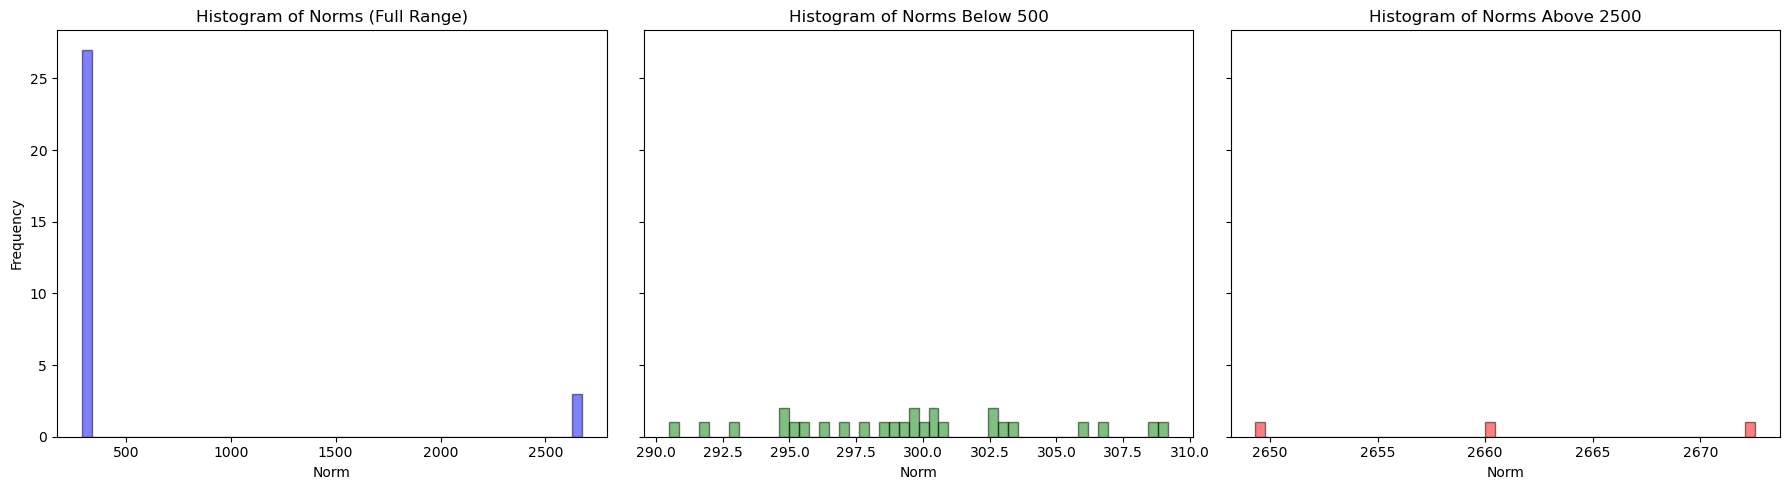

In [31]:
# Step 1: Load GPT-2 Small and Tokenizer
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2Model.from_pretrained(model_name)

# Fix: Assign a padding token
tokenizer.pad_token = tokenizer.eos_token

# Step 2: Hook to Extract Residual Stream After Layer 6
activation_vectors = []

def hook_fn(module, input, output):
    # Extract the first element if output is a tuple
    if isinstance(output, tuple):
        output = output[0]
    activation_vectors.append(output.clone().detach())

# Register the hook for the 6th layer
layer_idx = 5  # GPT-2 uses 0-based indexing for layers
model.h[5].register_forward_hook(hook_fn)

# Step 3: Process Input Text
texts = [
    "The quick brown fox jumps over the lazy dog.",
    "GPT-2 is an impressive language model.",
    "Transformers are revolutionizing NLP."
]

# Tokenize and Encode Texts
inputs = tokenizer(texts, return_tensors="pt", padding=True, truncation=True)
input_ids = inputs["input_ids"]

# Forward Pass to Capture Activations
with torch.no_grad():
    model(**inputs)

# Step 4: Subtract the Mean Activation
# Combine all activations into a single tensor
activations = torch.cat(activation_vectors, dim=0)  # Combine across all sentences/batches

# Subtract the mean activation to center the data
mean_activations = activations.mean(dim=1, keepdim=True)  # Compute mean along tokens
centered_activations = activations - mean_activations  # Subtract mean activation


# Step 5: Compute L2 Norms
norms = torch.norm(centered_activations, dim=-1)  # Norm across the hidden dimension


# Compute L2 norm for each token's activation vector
norms = torch.norm(centered_activations, dim=-1)  # Norm across the hidden dimension (e.g., 768)

# Flatten norms across all tokens and batches
norms_flattened = norms.flatten().cpu().numpy()  # Convert to numpy array for plotting




# Step 6: Plot a Histogram
plot_histograms(norms_flattened)



I plotted three different views of the norms. Most of the activations are 0, and very few are outliers, > 2500. This shows atterns in how activations are scaled across tokens and samples, how much LayerNorm is influencing activations and how some tokens have disproportionately high norms. Large norms suggest certain tokens or tasks are disproportionately activating the residual stream. 

LayerNorm may play a critical role in regulating these activations. Most norms fall into a consistent range (290–310), suggesting that LayerNorm effectively stabilizes activations for most tokens.

Outliers may correspond to special tokens or highly influential tokens.
Comparing this with a model trained without LayerNorm could reveal the stabilizing effect of LayerNorm and whether its removal affects these patterns.


In [33]:
norms_flattened

array([2660.0286 ,  296.09238,  297.0837 ,  292.7935 ,  291.95132,
        309.1923 ,  308.67447,  303.07242,  299.27045,  299.55746,
       2672.5417 ,  306.07767,  303.34454,  299.9945 ,  295.3005 ,
        302.75653,  299.4842 ,  300.6033 ,  297.72815,  300.3118 ,
       2649.321  ,  298.72226,  295.50613,  300.54028,  290.47665,
        302.82523,  306.5839 ,  298.54285,  294.69727,  294.62366],
      dtype=float32)

#### Task-Specific Analysis
Do norms behave differently for different tasks? Are some tasks more sensitive to LayerNorm removal?

In [24]:
import json

# Load the prompts
with open("task_specific_prompts.json", "r") as f:
    task_prompts = json.load(f)

# Example: Access prompts for a specific task
for task, prompts in task_prompts["tasks"].items():
    print(f"Task: {task}, Number of Prompts: {len(prompts)}")


Task: questions, Number of Prompts: 9
Task: summaries, Number of Prompts: 9
Task: statements, Number of Prompts: 9
Task: translations, Number of Prompts: 9
Task: definitions, Number of Prompts: 9
Task: opinions, Number of Prompts: 9
Task: longer_prompts, Number of Prompts: 7


In [26]:
# Dictionary to store norms for each task
task_norms = {}

for task, prompts in task_prompts["tasks"].items():  # Access prompts under "tasks"
    # Tokenize prompts (List[str] for batch processing)
    inputs = tokenizer(prompts, return_tensors="pt", padding=True, truncation=True)
    
    # Clear activation vectors for this task
    activation_vectors = []

    # Forward pass to capture activations
    with torch.no_grad():
        model(**inputs)
    
    # Compute norms
    activations = torch.cat(activation_vectors, dim=0)
    mean_activations = activations.mean(dim=1, keepdim=True)
    centered_activations = activations - mean_activations
    norms = torch.norm(centered_activations, dim=-1).flatten().cpu().numpy()
    
    # Store norms for this task
    task_norms[task] = norms

# Example: Print task norms summary
for task, norms in task_norms.items():
    print(f"Task: {task}, Number of Norms: {len(norms)}, Mean Norm: {norms.mean():.2f}")


Task: questions, Number of Norms: 117, Mean Norm: 420.26
Task: summaries, Number of Norms: 207, Mean Norm: 250.69
Task: statements, Number of Norms: 117, Mean Norm: 423.03
Task: translations, Number of Norms: 135, Mean Norm: 367.62
Task: definitions, Number of Norms: 126, Mean Norm: 389.85
Task: opinions, Number of Norms: 99, Mean Norm: 489.75
Task: longer_prompts, Number of Norms: 203, Mean Norm: 204.62


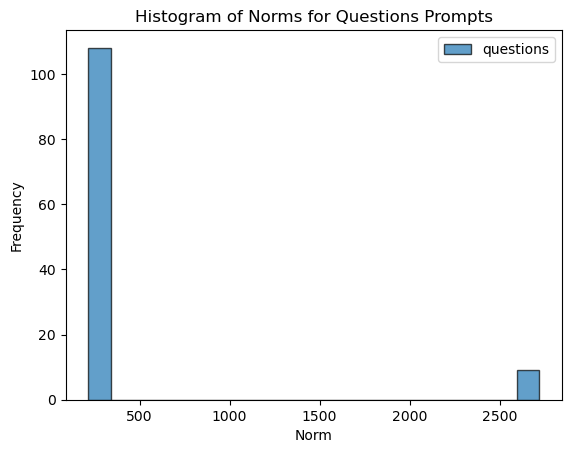

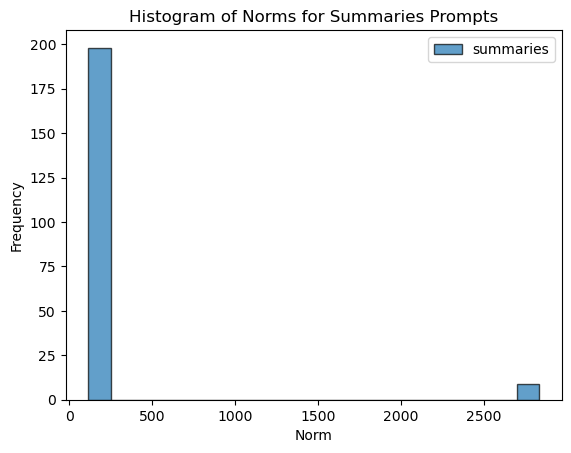

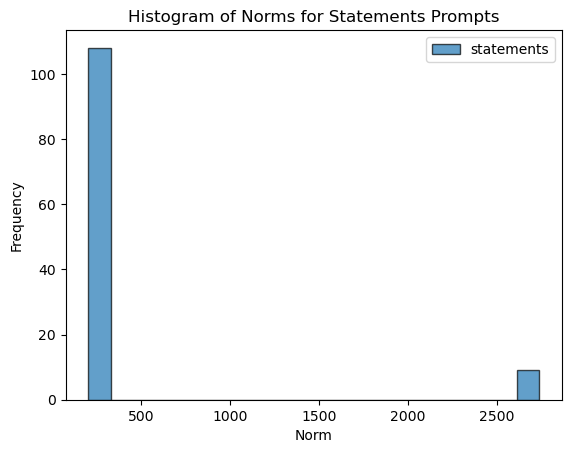

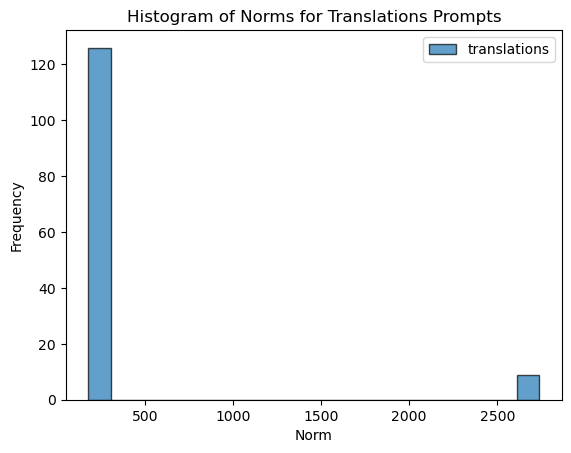

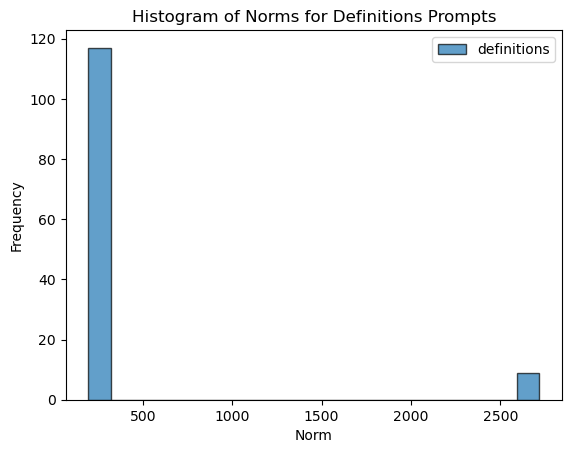

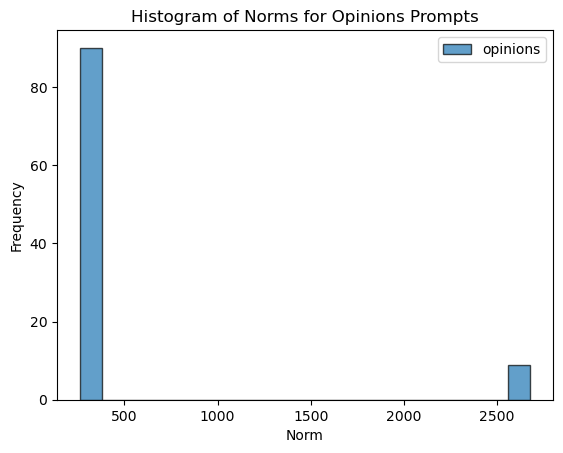

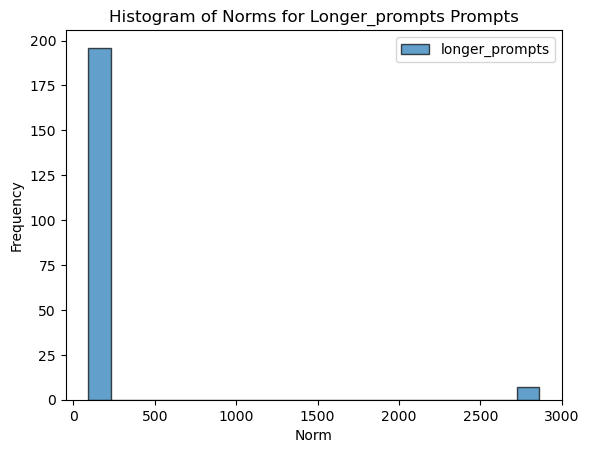

In [27]:
# Plot histograms for each task
for task, norms in task_norms.items():
    plt.hist(norms, bins=20, alpha=0.7, label=task, edgecolor='black')
    plt.title(f"Histogram of Norms for {task.capitalize()} Prompts")
    plt.xlabel("Norm")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


In [20]:
for task, norms in task_norms.items():
    mean = np.mean(norms)
    variance = np.var(norms)
    std_dev = np.std(norms)
    print(f"{task.capitalize()} Prompts:")
    print(f"  Mean: {mean:.2f}")
    print(f"  Variance: {variance:.2f}")
    print(f"  Standard Deviation: {std_dev:.2f}")
    print()


Questions Prompts:
  Mean: 646.35
  Variance: 530923.81
  Standard Deviation: 728.65

Summaries Prompts:
  Mean: 391.81
  Variance: 412723.47
  Standard Deviation: 642.44

Statements Prompts:
  Mean: 535.59
  Variance: 501784.50
  Standard Deviation: 708.37

